In [1]:
!source ~/.zshrc

In [2]:
import os
from sodapy import Socrata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rtree
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt

# Establish SodaPy connection
# Establish env variables
username = os.getenv('soc_user')
password = os.getenv('soc_pass')
token = os.getenv('soc_app_token')

# Authenticate client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org", 
                 token, 
                 username=username, 
                 password=password,
                timeout=25)


In [3]:
# Read in neighborhoods
#divvy_stations = gpd.read_file('data/divvy_stations.csv')
chicago = gpd.read_file("data/Boundaries - Community Areas (current)", crs = {'init': 'epsg:4326'})

# Pull Divvy station through socrata API
station_data = client.get('bk89-9dk7')


In [4]:
# Create Pandas DF to fix long & lat
divvy_data = pd.DataFrame(station_data)

divvy_data['longitude'] = divvy_data['longitude'].apply(lambda x: float(x))
divvy_data['latitude'] = divvy_data['latitude'].apply(lambda x: float(x))

In [6]:
# Move Divvy Station data to GeoDataFrame

all_divvy_stations = gpd.GeoDataFrame(divvy_data, geometry = gpd.points_from_xy(divvy_data['longitude'], divvy_data['latitude']))

# Rename columns
all_divvy_stations.rename(columns={':@computed_region_awaf_s7ux':'Historical Wards 2003-2015',
                              ':@computed_region_6mkv_f3dw':'Zip Codes',
                              ':@computed_region_vrxf_vc4k':'Community Areas',
                              ':@computed_region_bdys_3d7i':'Census Tracts',
                              ':@computed_region_43wa_7qmu':'Wards'},
                     inplace=True)

all_divvy_stations = all_divvy_stations.drop(['Zip Codes', 'location'], axis=1)
all_divvy_stations.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   station_name                595 non-null    object  
 1   Wards                       581 non-null    object  
 2   total_docks                 595 non-null    object  
 3   latitude                    595 non-null    float64 
 4   Historical Wards 2003-2015  581 non-null    object  
 5   longitude                   595 non-null    float64 
 6   Census Tracts               581 non-null    object  
 7   status                      595 non-null    object  
 8   Community Areas             581 non-null    object  
 9   docks_in_service            595 non-null    object  
 10  id                          595 non-null    object  
 11  geometry                    595 non-null    geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 55.9+ KB


In [8]:
# Inspect Chicago Ward Data
chicago.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   area        77 non-null     float64 
 1   area_num_1  77 non-null     object  
 2   area_numbe  77 non-null     object  
 3   comarea     77 non-null     float64 
 4   comarea_id  77 non-null     float64 
 5   community   77 non-null     object  
 6   perimeter   77 non-null     float64 
 7   shape_area  77 non-null     float64 
 8   shape_len   77 non-null     float64 
 9   geometry    77 non-null     geometry
dtypes: float64(6), geometry(1), object(3)
memory usage: 6.1+ KB


In [18]:
# Define Chicago Side Groups

far_north_side = ['76', '9', '10', '11', '12', '13', '14', '4', '2', '3', '77', '1']
northwest_side = ['17', '18', '19', '20', '15', '16']
north_side = ['22', '21', '5', '6', '7']
west_side = ['25', '26', '27', '23', '24', '28', '29', '31', '30']
central = ['33', '32', '8']
south_side = ['60', '37', '34', '35', '36', '40', '41', '42', '69', '43', '38', '39']
southwest_side = ['56', '64', '65', '66', '67', '68', '62', '63', '61', '57', '58', '59']
far_southwest_side = ['74', '75', '72', '73', '71', '70']
far_south_side = ['55', '54', '51', '49', '53', '50', '44', '47', '45', '46', '48', '46', '52']
# All Wards List
all_wards = far_north_side + northwest_side + north_side + west_side + central + south_side + far_southwest_side + southwest_side + far_south_side


In [19]:
# Define Function to Assign Groups

def assign_sides(ward):
    if ward in far_north_side:
        return "far north side"
    elif ward in northwest_side:
        return "northwest side"
    elif ward in north_side:
        return "north side"
    elif ward in west_side:
        return "west side"
    elif ward in central:
        return "loop"
    elif ward in south_side:
        return "south side"
    elif ward in southwest_side:
        return "southwest side"
    elif ward in far_southwest_side:
        return "far southwest side"
    elif ward in far_south_side:
        return "far south side"
    else:
        return "None"

In [23]:
# Assign Groups
chicago['side'] = chicago['area_num_1'].apply(lambda x: assign_sides(x))
all_divvy_stations['side'] = all_divvy_stations['Community Areas'].apply(lambda x: assign_sides(x))

# Drop Areas not in City
chicago = chicago[chicago['side']!='None']
all_divvy_stations[all_divvy_stations['side']=='loop']

,station_name,Wards,total_docks,latitude,Historical Wards 2003-2015,longitude,Census Tracts,status,Community Areas,docks_in_service,id,geometry,side
0,Ellis Ave & 53rd St,33,11,41.799336,32,-87.600958,441,In Service,8,11,418,POINT (-87.60096 41.79934),loop
2,Kimbark Ave & 53rd St,10,19,41.799568,1,-87.594747,499,In Service,8,19,322,POINT (-87.59475 41.79957),loop
23,Clinton St & 18th St,26,15,41.857950,8,-87.640826,126,In Service,33,15,170,POINT (-87.64083 41.85795),loop
46,Paulina St & 18th St,26,15,41.857901,8,-87.668745,343,In Service,33,15,205,POINT (-87.66875 41.85790),loop
60,Racine Ave & 18th St,26,15,41.858166,8,-87.656495,365,In Service,33,15,15,POINT (-87.65650 41.85817),loop
62,Lake Park Ave & 56th St,33,19,41.793242,32,-87.587782,502,In Service,8,19,345,POINT (-87.58778 41.79324),loop
121,Western Ave & 21st St,23,15,41.854109,8,-87.685838,4,In Service,33,15,203,POINT (-87.68584 41.85411),loop
152,Morgan St & 18th St,26,15,41.858086,8,-87.651073,228,In Service,33,15,14,POINT (-87.65107 41.85809),loop
196,Damen Ave & Coulter St,26,7,41.849200,8,-87.675640,126,In Service,33,7,167,POINT (-87.67564 41.84920),loop
213,Western Ave & 24th St,26,7,41.848470,8,-87.685109,204,In Service,33,7,281,POINT (-87.68511 41.84847),loop


In [21]:
# Remove Stations without Wards
divvy_stations_no_wards = all_divvy_stations[all_divvy_stations['Wards'].isna()==True]

divvy_stations = all_divvy_stations[all_divvy_stations['Wards'].isna()==False]
print(divvy_stations_no_wards.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14 entries, 4 to 423
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   station_name                14 non-null     object  
 1   Wards                       0 non-null      object  
 2   total_docks                 14 non-null     object  
 3   latitude                    14 non-null     float64 
 4   Historical Wards 2003-2015  0 non-null      object  
 5   longitude                   14 non-null     float64 
 6   Census Tracts               0 non-null      object  
 7   status                      14 non-null     object  
 8   Community Areas             0 non-null      object  
 9   docks_in_service            14 non-null     object  
 10  id                          14 non-null     object  
 11  geometry                    14 non-null     geometry
 12  side                        14 non-null     object  
dtypes: float64(2)

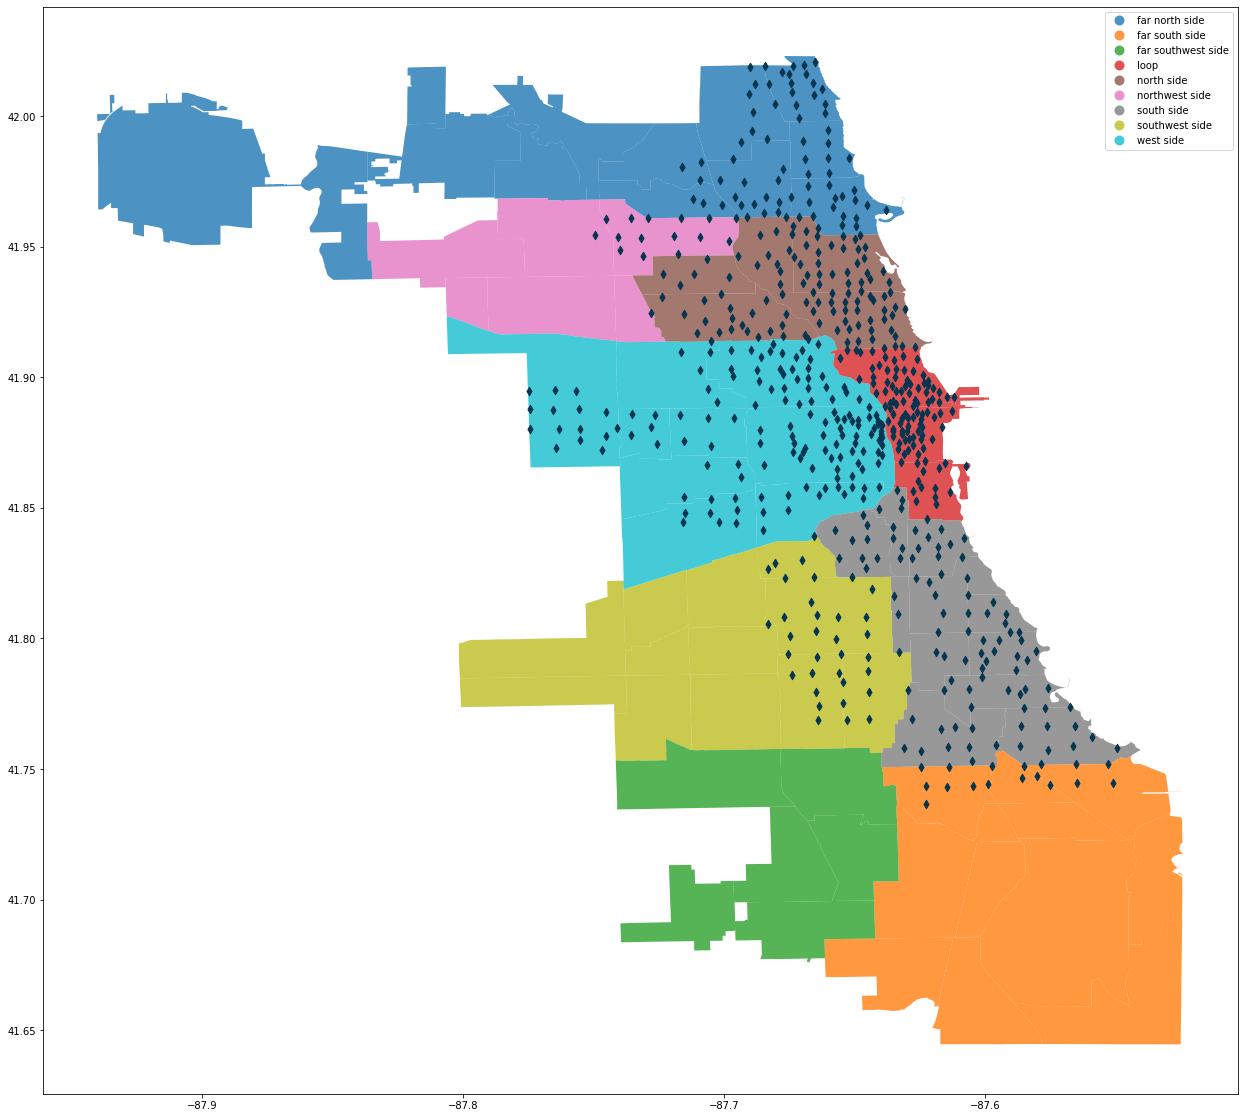

In [22]:
base = chicago.plot(figsize=(30,20), alpha=0.8, column='side', legend = True)

divvy_stations.plot(ax=base, figsize=(30,20), marker ='d', color='#063550')

In [17]:
# High Level Analysis on Divvy stations by general area of Chicago
station_agg_by_side = divvy_stations.groupby('side').agg({'id':'size'})
station_agg_by_side

,id
side,
far north side,66
far south side,11
loop,35
north side,28
northwest side,22
south side,138
southwest side,125
west side,156
